In [5]:
import os
import random
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import transforms as T
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from tensorboardX import SummaryWriter
from sklearn.model_selection import train_test_split
import albumentations as A
from image_loader import ImageLoader, PatchGenerator
import yaml

data = yaml.load(open('./settings.yaml', 'r'), yaml.Loader)

images_path = data['images_path']
masks_path = data['masks_path']
image_patches_path = data['image_patches_path']
mask_patches_path = data['mask_patches_path']

patch_size = data['patch_size']
sigma = data['sigma']
num_neg_samples = data['num_neg_samples']

transform = A.Compose([
    A.RandomRotate90(p=1),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

train_set = []
val_set = []

for i in [10, 20, 30, 40]:
    train_set.append("Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted{}.png".format(i))
for i in [50]:
    val_set.append("Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted{}.png".format(i))
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks):
        self.imgs = imgs
        self.masks = masks

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        im = self.imgs[index]
        mask = self.masks[index]
        
        im = im.reshape([1, im.shape[0], im.shape[1]])
        mask = mask.reshape([1, mask.shape[0], mask.shape[1]])
                                    
        return tuple([im, mask])
    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)
    
train_ds = []
val_ds = []

for image_set, ds in [[train_set, train_ds], [val_set, val_ds]]:
    for image in image_set:
        print("Image:", image)
        patch_names = [file for file in os.listdir(os.path.join(image_patches_path, image)) if file[-4:] == '.npy']
        for patch in tqdm(range(len(patch_names))):
            image_patch = np.load(os.path.join(image_patches_path, image, patch_names[patch]))
            mask_patch = np.load(os.path.join(mask_patches_path, image, patch_names[patch]))
            ds.append(np.array([image_patch, mask_patch]))
            
train_ds = np.array(train_ds)
val_ds = np.array(val_ds)

train_ds = Dataset(train_ds[:, 0], train_ds[:, 1])
val_ds = Dataset(val_ds[:, 0], val_ds[:, 1])

train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_ds, shuffle=False, batch_size=1)

epochs = 2000
lr = 0.5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet = UNet(n_channels=1, n_classes=1).to(device)
lossFunc = nn.MSELoss()
opt = torch.optim.SGD(unet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100, eta_min=0)

Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted10.png


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 817/817 [00:03<00:00, 263.51it/s]


Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted20.png


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 836/836 [00:03<00:00, 264.88it/s]


Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted30.png


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 823/823 [00:03<00:00, 249.83it/s]


Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted40.png


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 825/825 [00:03<00:00, 259.89it/s]


Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted50.png


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 859/859 [00:03<00:00, 258.28it/s]


In [6]:
model_path = './2023.05.14 with_neg/model_saves/model_psize=200, dihedral_4, epoch=2000.pth'
unet.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

unet.eval()
plt.figure(figsize=[4.4 * 3, 4.4 * 50])
# plt.figure(figsize=[1 * 3, 1 * len(val_loader)])


with torch.no_grad():
    counter = 0
    for x, y in val_loader:
        x = x.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.float)

        pred = unet(x)
        loss = lossFunc(pred, y)
        
        x = x.detach().cpu().numpy().squeeze()
        y = y.detach().cpu().numpy().squeeze()
        pred = pred.detach().cpu().numpy().squeeze()
        
        plt.subplot(50, 3, 3 * counter + 1)
        plt.axis('off')
        plt.title('x')
        plt.imshow(x, cmap='Greys_r')
        
        plt.subplot(50, 3, 3 * counter + 2)
        plt.axis('off')
        plt.title('y')
        plt.imshow(y, cmap='jet')
        
        plt.subplot(50, 3, 3 * counter + 3)
        plt.axis('off')
        plt.title('pred, mse_loss = {:.5f}'.format(loss))
        plt.imshow(pred, cmap='jet')
        
        counter += 1
        if counter == 50:
            break
        
_ = plt.show()

In [18]:
trial_img = './dataset/images/Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted50.png'
trial_mask = './dataset/masks/Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted50.png.npy'

trial_img = plt.imread(trial_img)
trial_mask = np.load(trial_mask)
prediction = np.zeros(trial_mask.shape)

overlap_factor = 2

for y in tqdm(range(0, trial_img.shape[0] - patch_size, int(patch_size // overlap_factor))):
    for x in range(0, trial_img.shape[1] - patch_size, int(patch_size // overlap_factor)):
        patch = trial_img[y:y+patch_size, x:x+patch_size].reshape([1, 1, patch_size, patch_size])
        patch = torch.Tensor(patch)
        patch = patch.to(device, dtype=torch.float)
        patch_pred = unet(patch)
        patch_pred = patch_pred.detach().cpu().numpy().squeeze()
        prediction[y:y+patch_size, x:x+patch_size] = np.maximum(prediction[y:y+patch_size, x:x+patch_size], patch_pred)
        
# taking care of edges + lower right corner
        
y = trial_img.shape[0] - patch_size
for x in tqdm(range(0, trial_img.shape[1] - patch_size, int(patch_size // overlap_factor))):
    patch = trial_img[y:y+patch_size, x:x+patch_size].reshape([1, 1, patch_size, patch_size])
    patch = torch.Tensor(patch)
    patch = patch.to(device, dtype=torch.float)
    patch_pred = unet(patch)
    patch_pred = patch_pred.detach().cpu().numpy().squeeze()
    prediction[y:y+patch_size, x:x+patch_size] = np.maximum(prediction[y:y+patch_size, x:x+patch_size], patch_pred)
        
x = trial_img.shape[1] - patch_size
for y in tqdm(range(0, trial_img.shape[0] - patch_size, int(patch_size // overlap_factor))):
    patch = trial_img[y:y+patch_size, x:x+patch_size].reshape([1, 1, patch_size, patch_size])
    patch = torch.Tensor(patch)
    patch = patch.to(device, dtype=torch.float)
    patch_pred = unet(patch)
    patch_pred = patch_pred.detach().cpu().numpy().squeeze()
    prediction[y:y+patch_size, x:x+patch_size] = np.maximum(prediction[y:y+patch_size, x:x+patch_size], patch_pred)
    
y = trial_img.shape[0] - patch_size
x = trial_img.shape[1] - patch_size
patch = trial_img[y:y+patch_size, x:x+patch_size].reshape([1, 1, patch_size, patch_size])
patch = torch.Tensor(patch)
patch = patch.to(device, dtype=torch.float)
patch_pred = unet(patch)
patch_pred = patch_pred.detach().cpu().numpy().squeeze()
prediction[y:y+patch_size, x:x+patch_size] = np.maximum(prediction[y:y+patch_size, x:x+patch_size], patch_pred)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 297.88it/s]


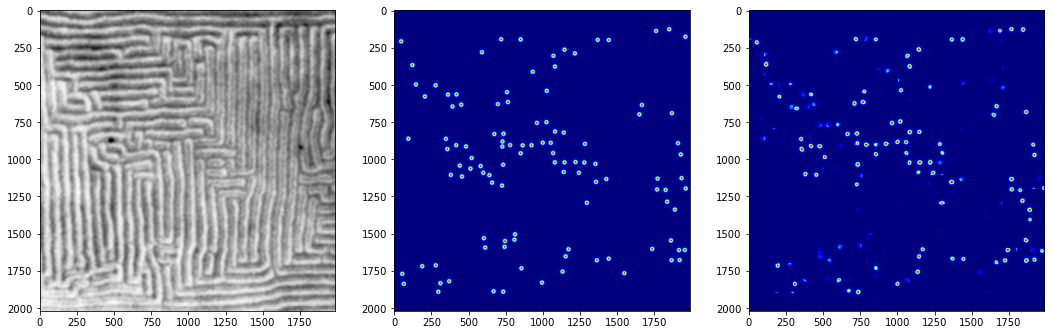

In [20]:
plt.figure(figsize=[6 * 3, 6 * 1])
plt.subplot(1, 3, 1)
plt.imshow(trial_img, cmap='Greys_r')
plt.subplot(1, 3, 2)
plt.imshow(trial_mask, cmap='jet')
plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap='jet')